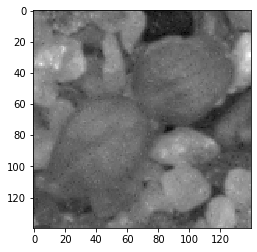

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
path = '../data/plant-seedlings-classification/train/Cleavers/'
file = '0b44c3a6c.png'
img_path = path + file

# load color image 
bgr_img = cv2.imread(img_path)
# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255

# plot image
plt.imshow(gray_img, cmap='gray')
plt.show()

#### Filters

In [123]:
import numpy as np
from scipy import ndimage
im = np.zeros((4, 4))
filter_1 = ndimage.sobel(im, axis=1, mode='constant')
#filter_1 = np.ones([4,4])/16. # blur
filter_3 = np.array([
        [-2,-2.,-2,-2.],
        [0,0,0,0],
        [0,0.,0,0],
        [2,2,2,2],
])

filter_2 =np.array([
       [62,8,8,8],
       [8,0,0,8],
       [8,0,0,8],
       [8,8,8,93.]
])
filter_4 = np.eye(4)/16.


In [124]:
filter_3

array([[-2., -2., -2., -2.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 2.,  2.,  2.,  2.]])

In [125]:

filters = np.array([filter_1, filter_2, filter_3, filter_4])

# For an example, print out the values of filter 1
print('Filter 1: \n', filter_1)

Filter 1: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [126]:
filters.dtype

dtype('float64')

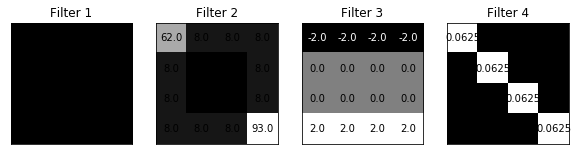

In [127]:
# visualize all four filters
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    width, height = filters[i].shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
# define a neural network with a single convolutional layer with four filters
class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        # initializes the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weight.shape[2:]
        # defines the convolutional layer, assumes there are 4 grayscale filters
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv = nn.Conv2d(4, 4, kernel_size=(k_height, k_width), bias=False,stride=1,padding=1)
        self.conv.weight = torch.nn.Parameter(weight)

    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        
        # returns both layers
        return conv_x, activated_x
    
# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Net(weight)

# print out the layer in the network
print(model)

Net(
  (conv): Conv2d(4, 4, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
)


In [129]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

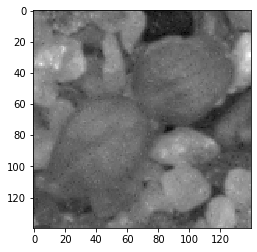

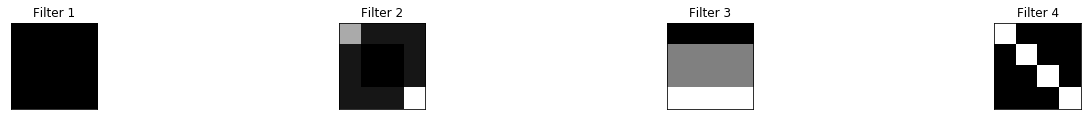

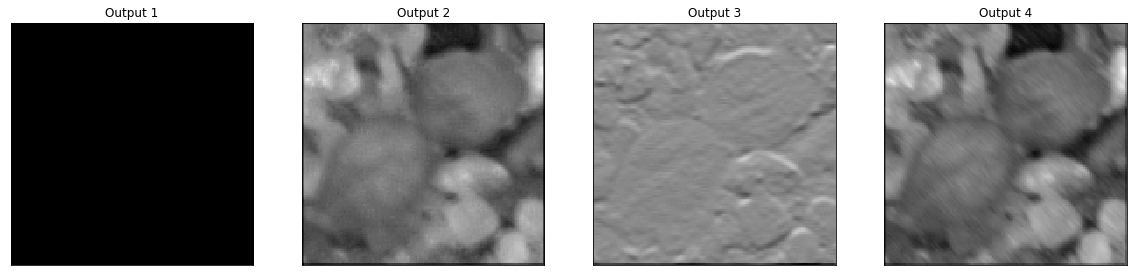

In [130]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get the convolutional layer (pre and post activation)
conv_layer, activated_layer = model(gray_img_tensor)

# visualize the output of a conv layer
viz_layer(conv_layer)

#### Visualise pooling layer

In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
# define a neural network with a convolutional layer with four filters
# AND a pooling layer of size (2, 2)
class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        # initializes the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weight.shape[2:]
        # defines the convolutional layer, assumes there are 4 grayscale filters
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv = nn.Conv2d(8, 16, kernel_size=(k_height, k_width), bias=False,stride = 1)
        self.conv.weight = torch.nn.Parameter(weight)
        # define a pooling layer
        self.pool = nn.MaxPool2d(16, 1)

    def forward(self, x):
        # calculates the output of a convolutional layer
        # pre- and post-activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        
        # applies pooling layer
        pooled_x = self.pool(activated_x)
        
        # returns all layers
        return conv_x, activated_x, pooled_x
    
# instantiate the model and set the weights
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Net(weight)

# print out the layer in the network
print(model)

Net(
  (conv): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=16, stride=1, padding=0, dilation=1, ceil_mode=False)
)


In [118]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1)
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

##### Activated Layer

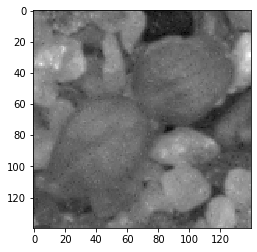

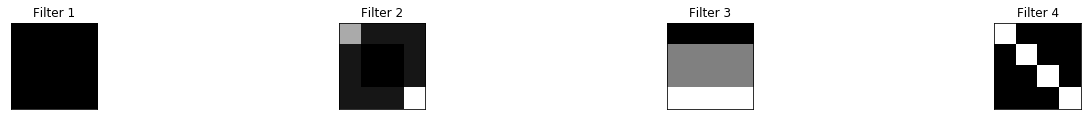

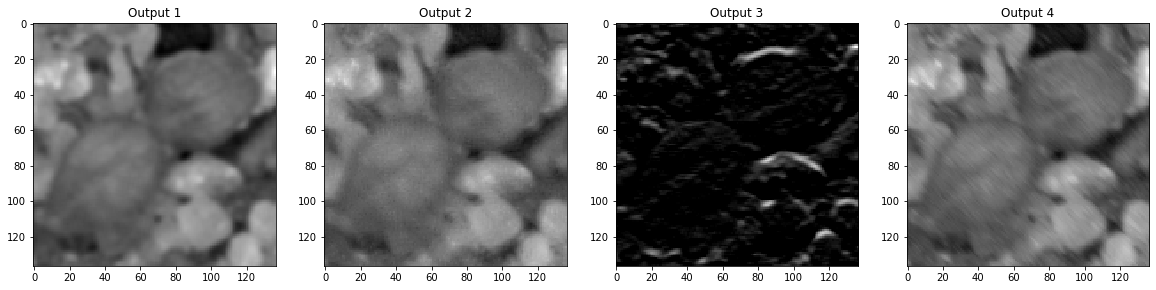

In [119]:
# plot original image
plt.imshow(gray_img, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

    
# convert the image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# get all the layers 
conv_layer, activated_layer, pooled_layer = model(gray_img_tensor)

# visualize the output of the activated conv layer
viz_layer(activated_layer)

##### Pooled Layer

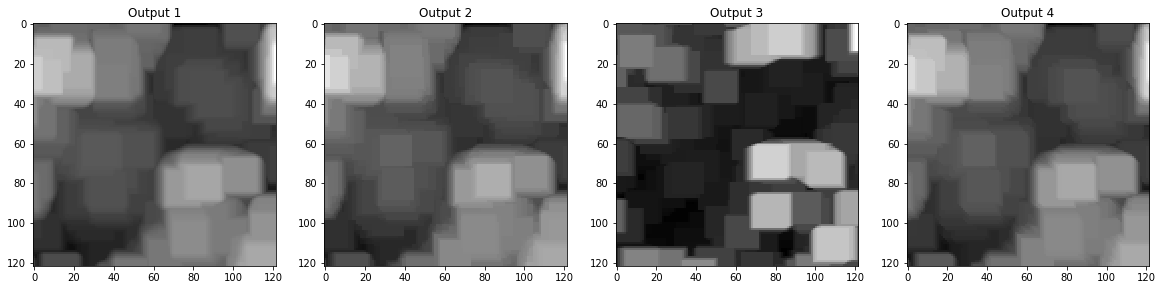

In [120]:
# visualize the output of the pooling layer
viz_layer(pooled_layer)